In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob2 as glob  # Using glob2 instead of glob
import os
from obspy import UTCDateTime
from obspy.core import Stream, Trace, Stats

In [2]:

# Function to read a GeoCSV file and convert to ObsPy Stream
def read_geocsv(file_path):
    # Read the header to get metadata
    metadata = {}
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('#'):
                parts = line.strip('# \n').split(': ', 1)
                if len(parts) == 2:
                    metadata[parts[0]] = parts[1]
            else:
                break

In [3]:
def read_geocsv(file_path):
    # Read the header to get metadata
    metadata = {}
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('#'):
                parts = line.strip('# \n').split(': ', 1)
                if len(parts) == 2:
                    metadata[parts[0]] = parts[1]
            else:
                break
    
    # Read the actual data
    data = pd.read_csv(file_path, comment='#')
    
    # Check column names and get the data column (which might not be named 'Sample')
    columns = data.columns.tolist()
    if len(columns) < 2:
        raise ValueError(f"CSV file {file_path} doesn't have enough columns")
    
    # Assuming the second column contains the sample data
    data_column = columns[1]
    
    # Extract key metadata
    sid = metadata.get('SID', 'unknown')
    
    # Properly handle SID with variable number of parts
    parts = sid.split('_')
    if len(parts) >= 3:
        network = parts[0]
        station = parts[1]
        channel = parts[-1]  # Last part is usually the channel
    else:
        network = ''
        station = sid
        channel = ''
    
    sample_rate = float(metadata.get('sample_rate_hz', 1.0))
    start_time = UTCDateTime(metadata.get('start_time', '2000-01-01T00:00:00Z'))
    
    # Create ObsPy Stats object
    stats = Stats({
        'network': network,
        'station': station,
        'channel': channel,
        'starttime': start_time,
        'sampling_rate': sample_rate,
        'npts': len(data)
    })
    
    # Create ObsPy Trace with the sample data, using the identified data column
    tr = Trace(data=np.array(data[data_column]), header=stats)
    
    return Stream(traces=[tr])

In [4]:
# Function to convert counts to acceleration (m/s^2)
def counts_to_acceleration(stream, sensitivity=1.0):
    """
    Convert counts to acceleration.
    
    Parameters:
    - stream: ObsPy Stream object
    - sensitivity: Instrument sensitivity in counts/(m/s^2)
    
    Returns:
    - Stream object with data in m/s^2
    """
    for tr in stream:
        # Apply instrument correction (simplified - in real applications you'd use response files)
        tr.data = tr.data / sensitivity
        tr.stats.units = 'm/s^2'
    
    return stream

In [5]:
# Function to process all files in a directory
def process_directory(directory):
    # Get all CSV files in the directory
    csv_files = glob.glob(os.path.join(directory, '*.csv'))
    
    streams = []
    for file in csv_files:
        print(f"Processing {file}")
        stream = read_geocsv(file)
        # Apply conversion to acceleration
        # Note: You would need the actual instrument sensitivity value
        accel_stream = counts_to_acceleration(stream, sensitivity=2800.0)  # Example value
        streams.append(accel_stream)
    
    return streams

In [6]:
# Function to plot accelerogram for a stream
def plot_accelerogram(stream, title=None):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for tr in stream:
        times = tr.times() + (tr.stats.starttime.timestamp - tr.stats.starttime.timestamp)
        ax.plot(times, tr.data, label=tr.stats.channel)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Acceleration (m/s²)')
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f'Accelerogram - {tr.stats.station}')
    ax.grid(True)
    ax.legend()
    
    plt.tight_layout()
    return fig

In [7]:
# Main processing
base_dir = '.'  # Adjust to your path
region = 'puerto-rico'  # Or loop through all regions

Processing .\puerto-rico\IU.SJG.00.BH1.M.2024-12-09T182040.019538.csv
Processing .\puerto-rico\IU.SJG.00.BH2.M.2024-12-09T182040.019538.csv
Processing .\puerto-rico\IU.SJG.00.BHZ.M.2024-12-09T182040.019538.csv
Processing .\puerto-rico\IU.SJG.10.BH1.M.2024-12-09T182040.019538.csv
Processing .\puerto-rico\IU.SJG.10.BH2.M.2024-12-09T182040.019538.csv
Processing .\puerto-rico\IU.SJG.10.BHZ.M.2024-12-09T182040.019538.csv


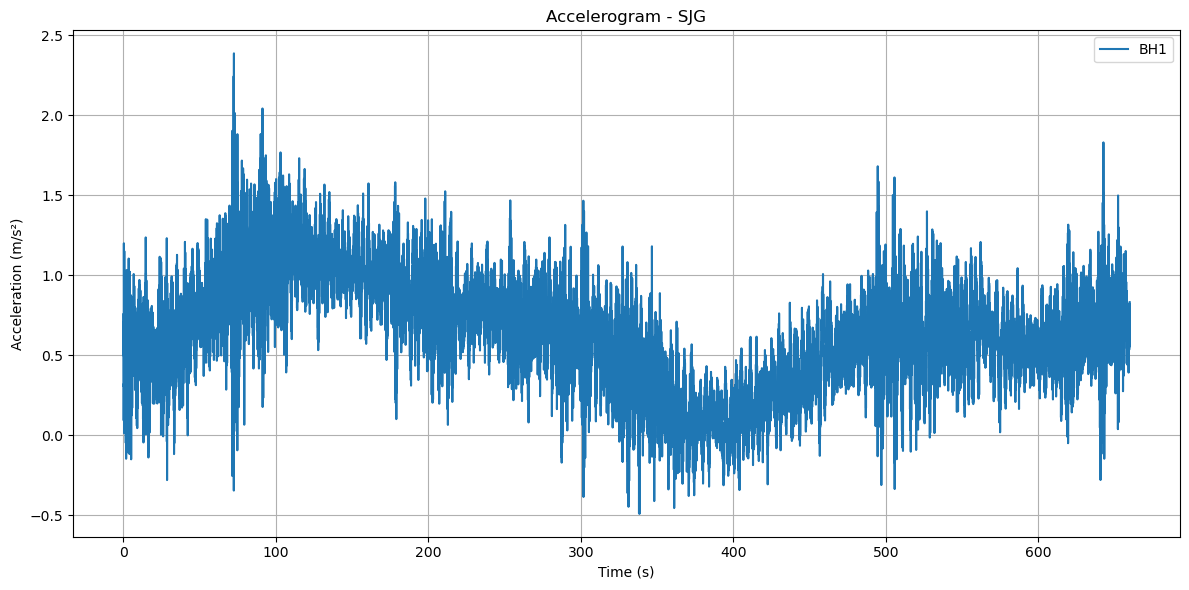

In [8]:
# Process files for a specific region
region_dir = os.path.join(base_dir, region)
streams = process_directory(region_dir)

# Example: Plot the first stream
if streams:
    fig = plot_accelerogram(streams[0])
    plt.show()
    
    # Save the plot if needed
    # fig.savefig(f"{region}_accelerogram.png", dpi=300)

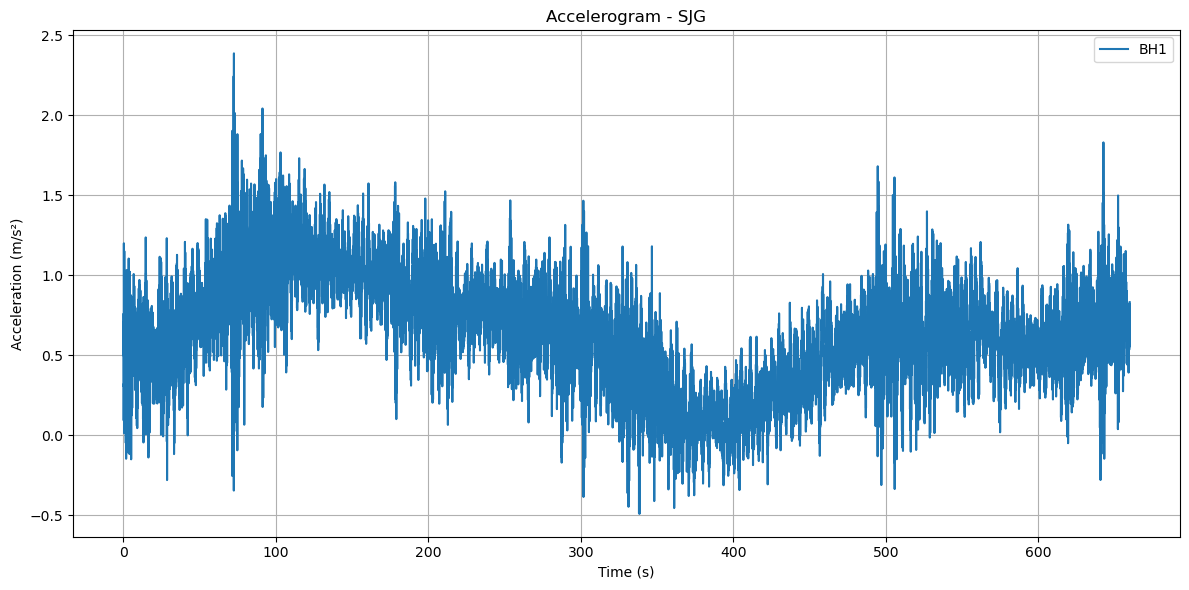

In [9]:
# Example: Plot the first stream
if streams:
    fig = plot_accelerogram(streams[0])
    plt.show()

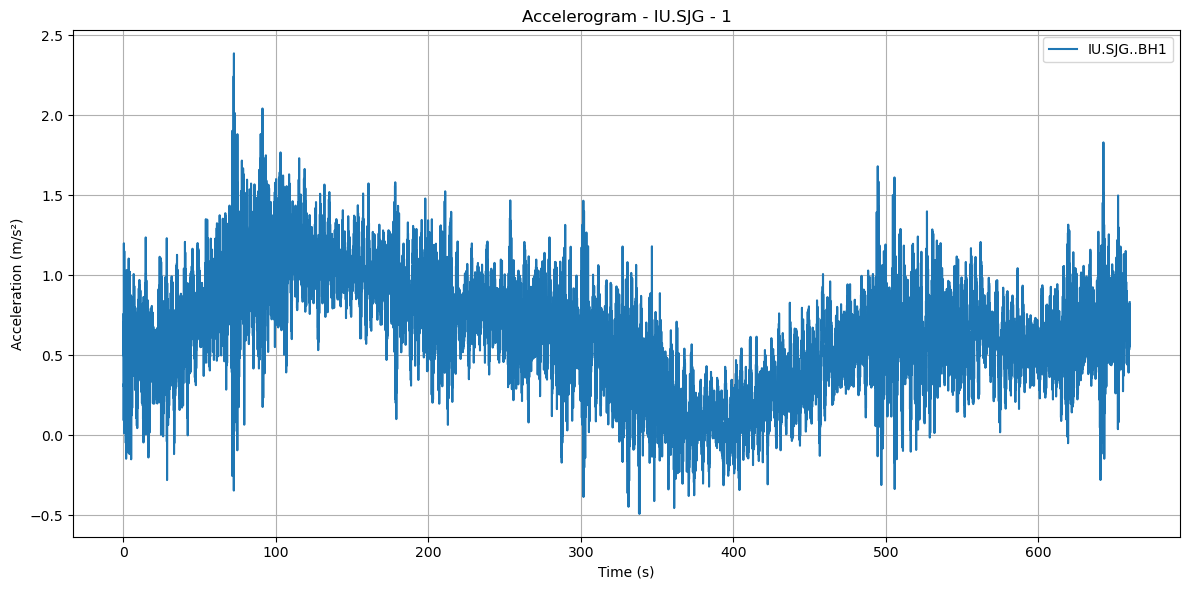

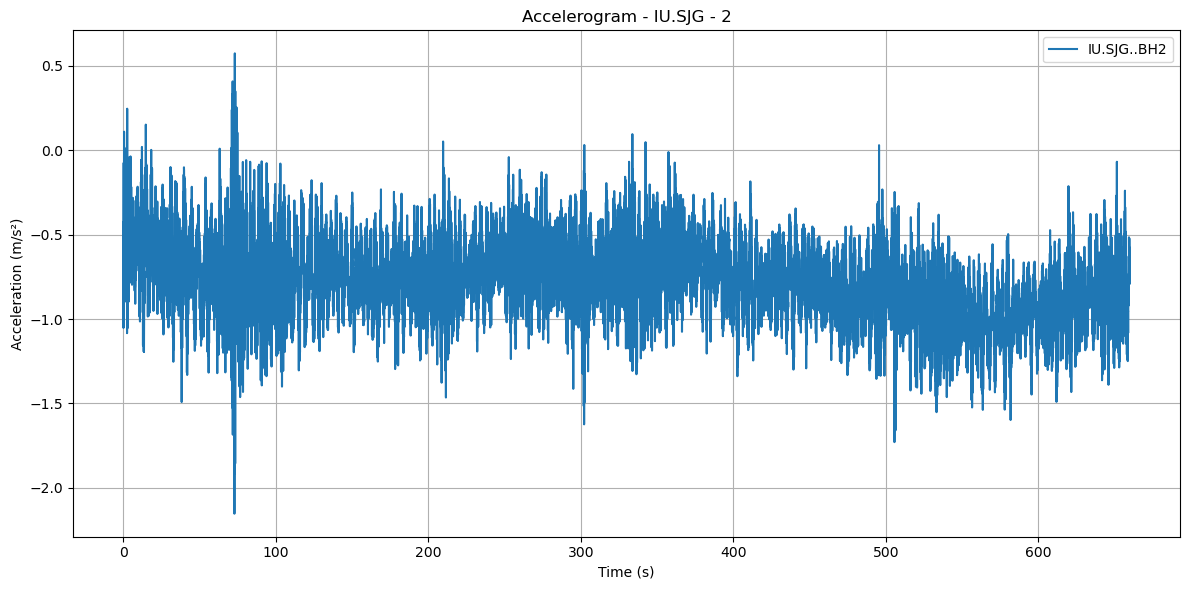

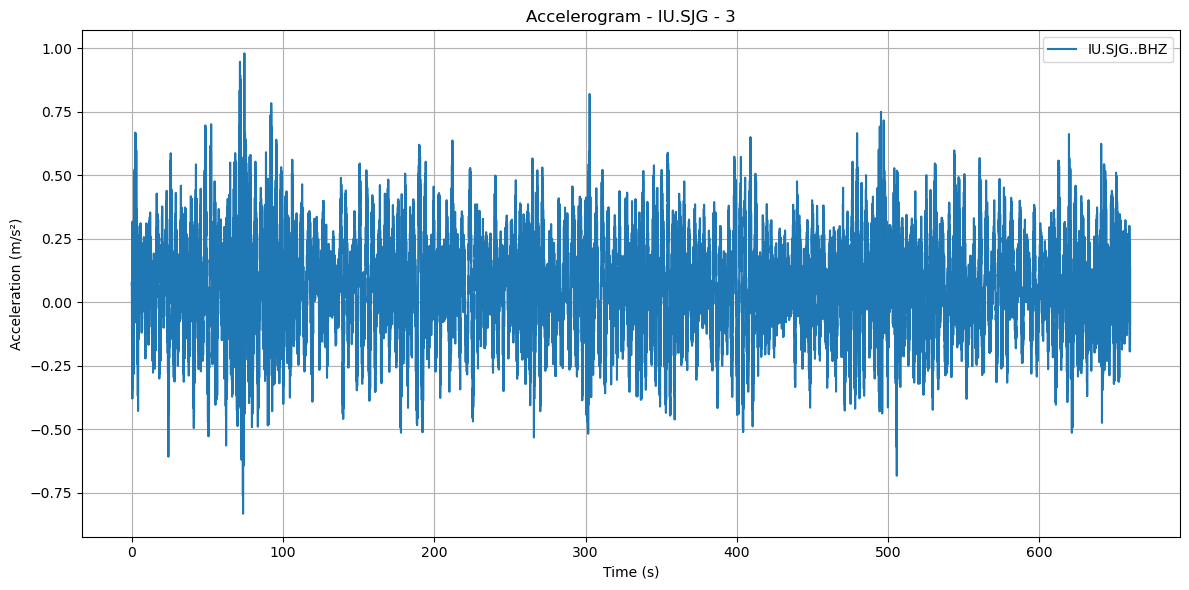

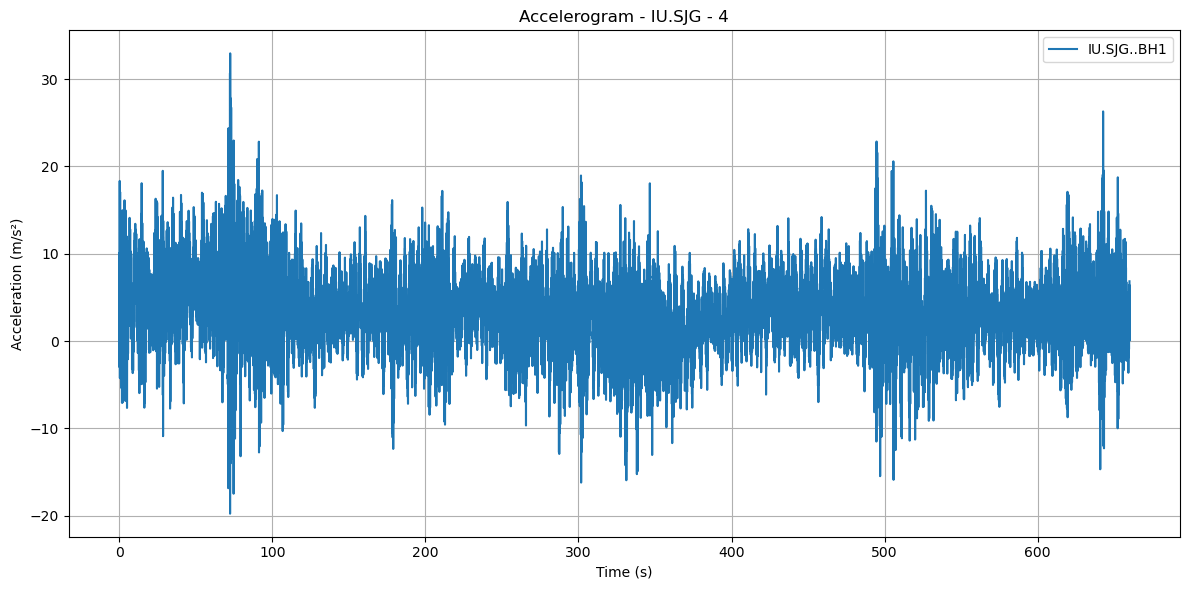

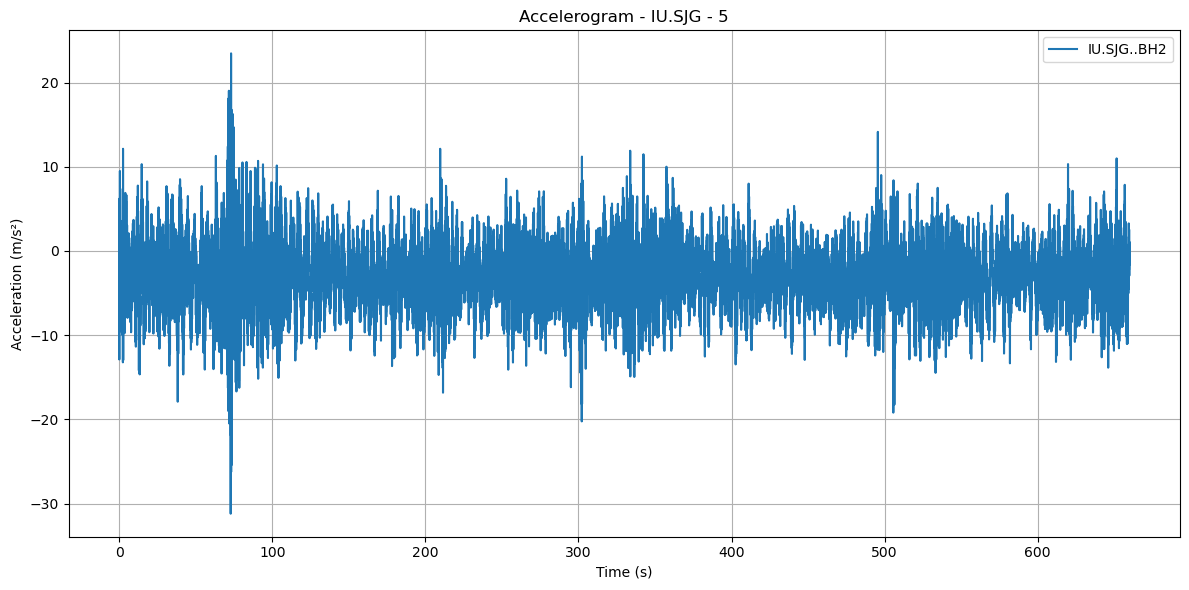

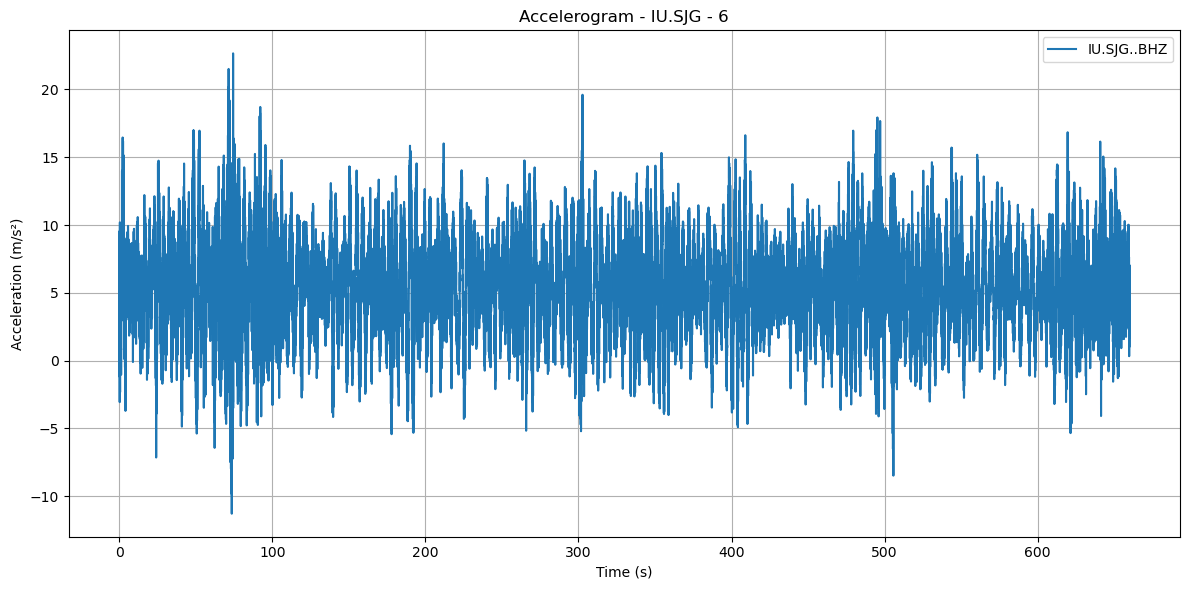

In [10]:
# Plot all streams in separate figures
for i, stream in enumerate(streams):
    fig = plt.figure(figsize=(12, 6))
    for tr in stream:
        times = tr.times() + (tr.stats.starttime.timestamp - tr.stats.starttime.timestamp)
        plt.plot(times, tr.data, label=f"{tr.stats.network}.{tr.stats.station}.{tr.stats.location}.{tr.stats.channel}")
    
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s²)')
    plt.title(f'Accelerogram - {stream[0].stats.network}.{stream[0].stats.station} - {i+1}')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

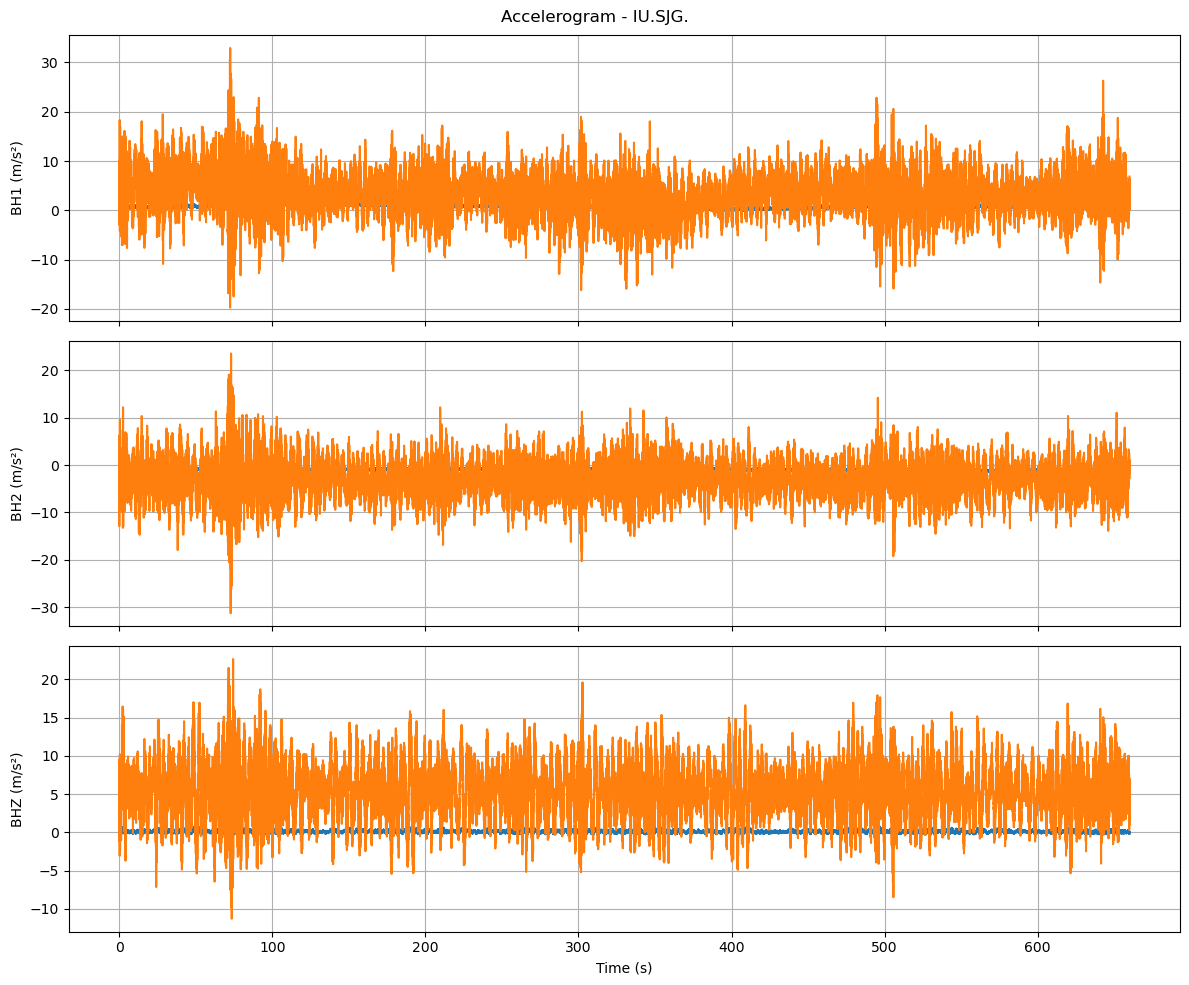

In [11]:
def combine_components(streams):
    """Group streams by station and location code, then plot the components together"""
    # Group by station and location
    stations = {}
    for stream in streams:
        for tr in stream:
            key = f"{tr.stats.network}.{tr.stats.station}.{tr.stats.location}"
            if key not in stations:
                stations[key] = Stream()
            stations[key] += Stream(traces=[tr])
    
    # Plot each station's components
    for station_key, stream in stations.items():
        fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
        
        components = {'BH1': 0, 'BH2': 1, 'BHZ': 2}
        
        for tr in stream:
            if tr.stats.channel in components:
                ax_idx = components[tr.stats.channel]
                times = tr.times() + (tr.stats.starttime.timestamp - tr.stats.starttime.timestamp)
                axs[ax_idx].plot(times, tr.data)
                axs[ax_idx].set_ylabel(f'{tr.stats.channel} (m/s²)')
                axs[ax_idx].grid(True)
                
        axs[2].set_xlabel('Time (s)')
        fig.suptitle(f'Accelerogram - {station_key}')
        plt.tight_layout()
        plt.show()

# Use this function after processing
combine_components(streams)